# Self exciting volatility

In this notebook we'll consider modelling the returns of [ENEL](https://www.enel.com/) utilizing a _self-exciting process_ TODO: model it. We begin by importing the necessary data

<AxesSubplot:xlabel='Date'>

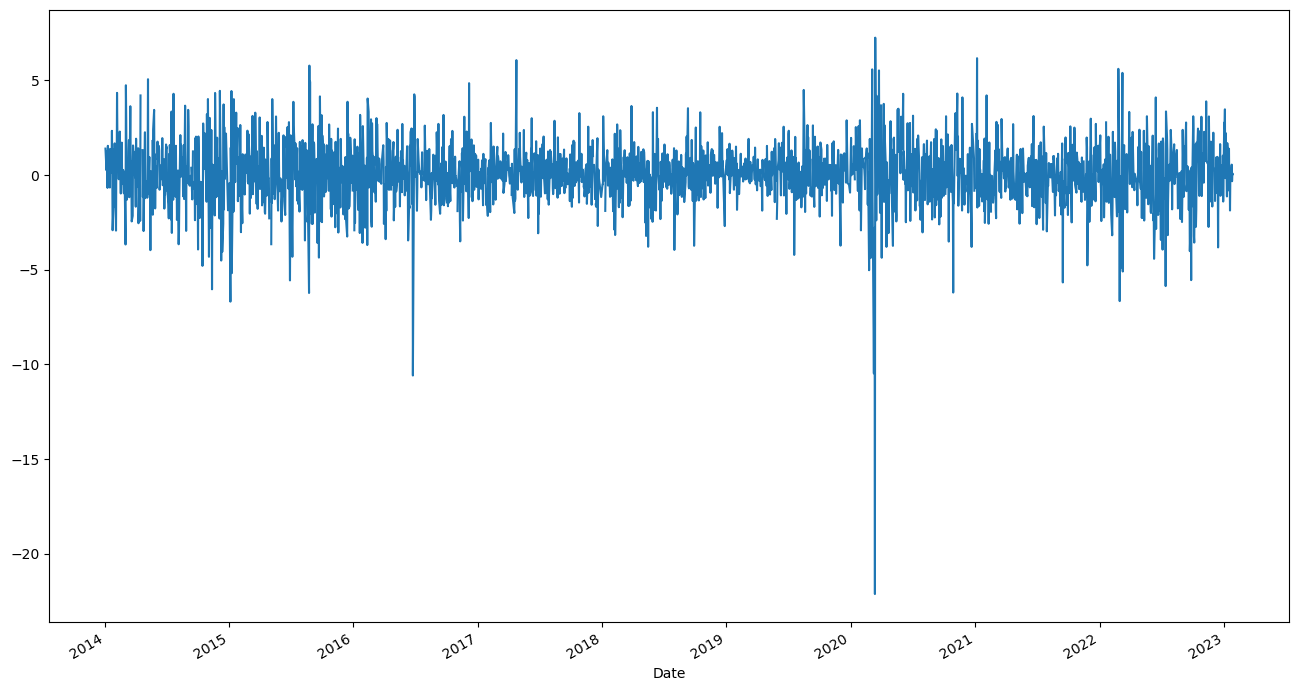

In [1]:
from yfinance import Ticker
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16, 9)

equity = Ticker("ENEL.MI")
history = equity.history(start="2014-01-01")

log_returns = np.log(history["Close"]).diff().iloc[1:] * 100.0

log_returns.where(log_returns != 0.0, np.nan, inplace=True)
log_returns.plot()

Next up, we'll perform the actual modelling. We import the model from [stoch-proc](https://github.com/tingiskhan/stoch-proc) and define the state space model

In [2]:
from stochproc.timeseries import StateSpaceModel, models
from stochproc.distributions import NegativeExponential
from pyfilter.inference import InferenceContext
from pyro.distributions import Exponential, LogNormal, Uniform, Normal, TransformedDistribution, transforms
import torch
from functools import partial


def build_observation(x, mu, sigma, dist):
    lamda_t = x.value[..., 0]
    q = x.value[..., 1]

    loc = mu - sigma ** 2.0 / 2.0 - lamda_t * (dist.phi_fun - 1.0) + q

    return Normal(loc, sigma)


def model(context: InferenceContext):
    # Intensity process
    alpha = context.named_parameter("alpha", Exponential(5.0).cuda())
    xi = context.named_parameter("xi", Uniform(0.0, 5.0).cuda())
    eta = context.named_parameter("eta", LogNormal(-2.0, 1.0).cuda())

    rho = context.named_parameter("rho", Uniform(0.0, 1.0).cuda())
    rho_minus = context.named_parameter("rho_minus", Uniform(1.0, 10.0).cuda())
    rho_plus = context.named_parameter("rho_plus", Uniform(1.0, 10.0).cuda())
    
    dt = 0.25
    intensity = models.SelfExcitingLatentProcesses(alpha, xi, eta, rho, rho_minus, rho_plus, dt=dt)

    # Observable
    mu = context.named_parameter("mu", Normal(0.0, 0.5).cuda())
    sigma = context.named_parameter("sigma", LogNormal(0.0, 1.0).cuda())
    f = partial(build_observation, dist=intensity.de)

    return StateSpaceModel(intensity, f, (mu, sigma), observe_every_step=int(1.0 / dt))

Next, we'll try to infer the parameters of the model

In [3]:
from pyfilter.inference.sequential import SMC2
from pyfilter.filters.particle import SISR
from pyfilter import inference

y = torch.from_numpy(log_returns.values).float().cuda()

with inference.make_context(use_quasi=True) as context:
    filt = SISR(model, 1_000)
    alg = SMC2(filt, 2_000, threshold=0.075, num_steps=10, distance_threshold=0.025)

    state = alg.fit(y)

SMC2: 100%|██████████| 2307/2307 [17:16<00:00,  2.23it/s]  


Let's plot the posteriors

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'xi'}>,
        <AxesSubplot:title={'center':'eta'}>],
       [<AxesSubplot:title={'center':'rho'}>,
        <AxesSubplot:title={'center':'rho_minus'}>,
        <AxesSubplot:title={'center':'rho_plus'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'sigma'}>, <AxesSubplot:>]],
      dtype=object)

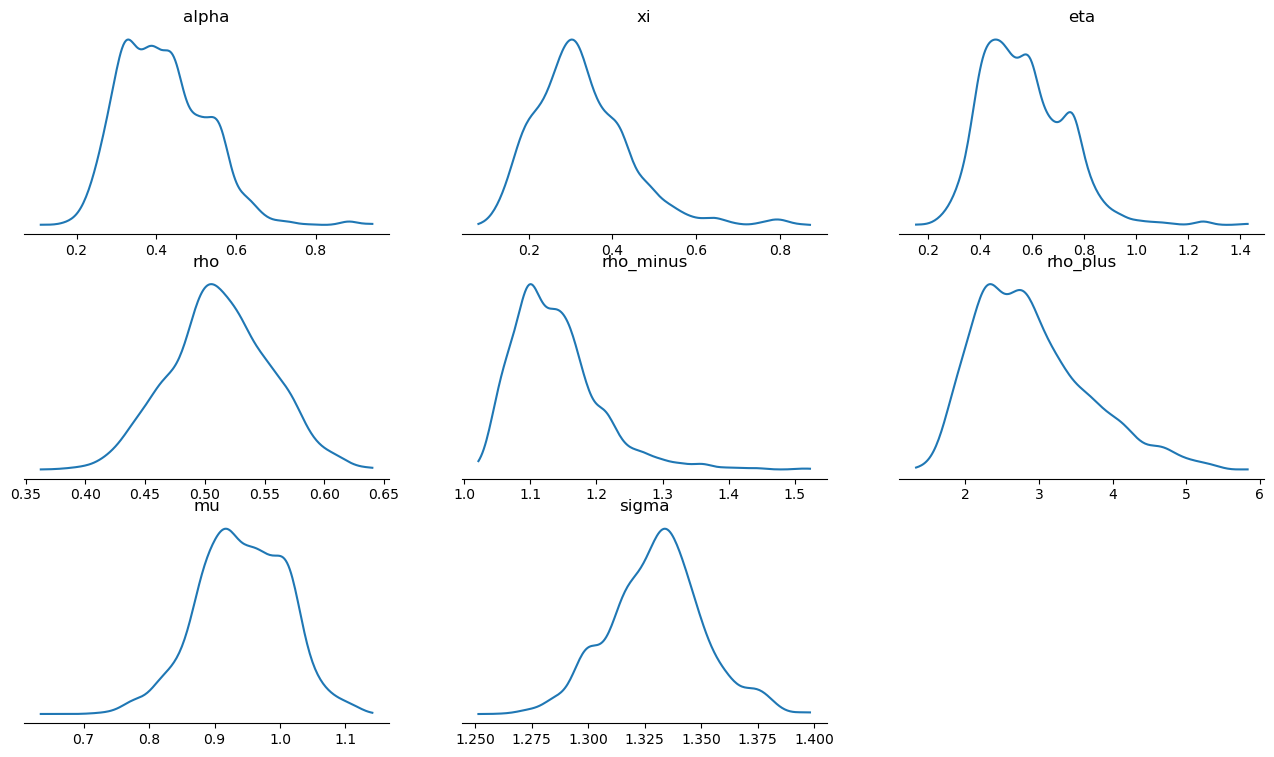

In [4]:
from pyfilter.inference import plot

plot.mimic_arviz_posterior(context, state)

And finally plot the posterior means of the states

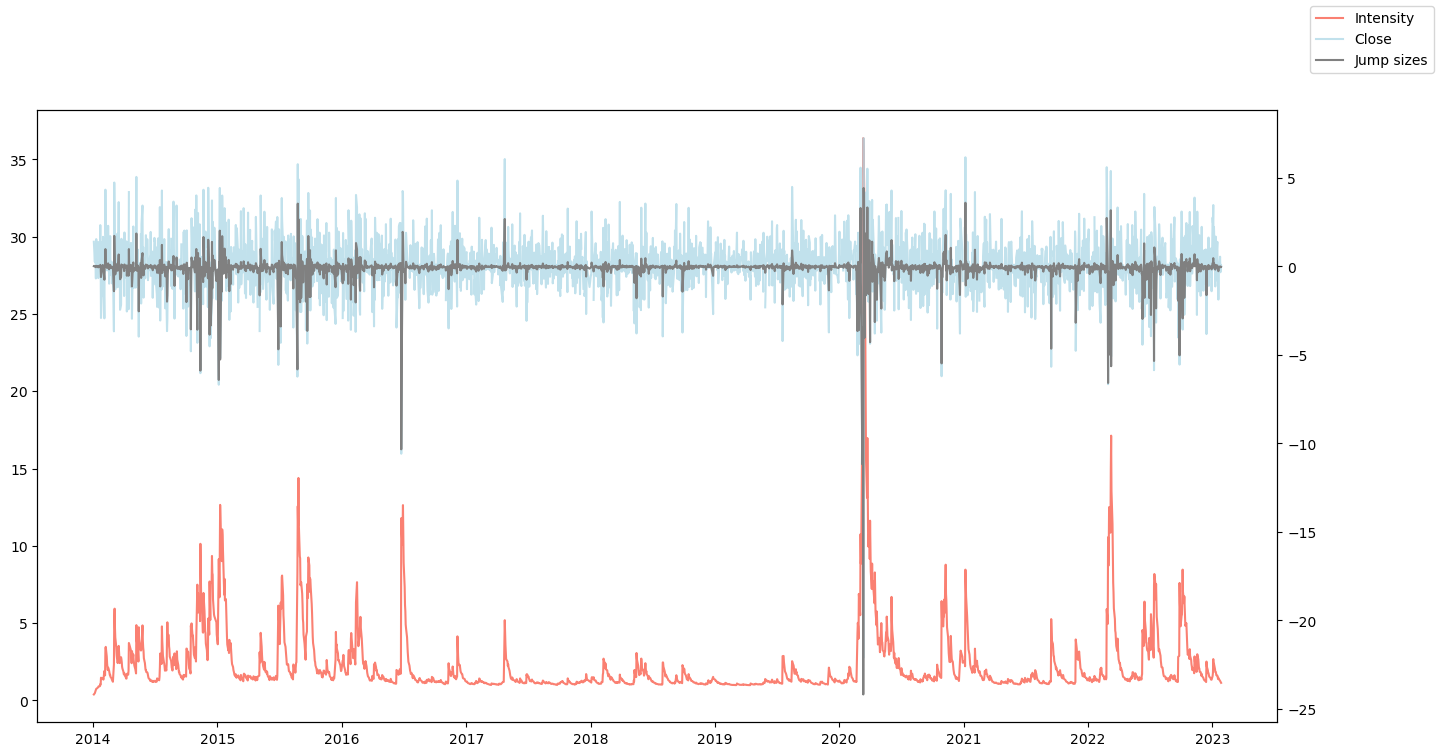

In [18]:
fig, ax = plt.subplots()

means = (state.normalized_weights() @ state.filter_state.filter_means).cpu().numpy()
ax.plot(log_returns.index, means[1:, 0], label="Intensity", color="salmon")

ax2 = ax.twinx()
log_returns.plot(ax=ax2, alpha=0.75, color="lightblue")
ax2.plot(log_returns.index, means[1:, 1], label="Jump sizes", color="gray")


fig.legend()